In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import floor
from celluloid import Camera
import gym
env = gym.make('MountainCar-v0')

### Exploration

In [2]:
env.reset()

(array([-0.51547366,  0.        ], dtype=float32), {})

In [3]:
# observation space
obs_space = env.observation_space
print("The observation space: {}".format(obs_space))

The observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)


In [4]:
# action space
action_space = env.action_space
print("The action space: {}".format(action_space))

The action space: Discrete(3)


In [5]:
print(env.action_space.sample())

1


### Q-Learning

source: https://medium.com/@bradfordgill/q-learning-with-numpy-mountain-car-feaef1c4ed1a

In [6]:
POSITION_SPACE = (-1.2, .6)
VELO_SPACE = (-.07, .07)
ACTION_SPACE = [-1, 0, 1]
START_RANGE = (-.6, -.4)

In [7]:
class Q_table():
    def __init__(self, discrete_ps = 30, discrete_vs = 30, discrete_as = 3):
        """
        discrete_ps: positon dim length 
        discrete_vs: velocity dim length 
        discrete_as: actions dim length 
        """
        self.p_len, self.v_len, self.a_len = discrete_ps, discrete_vs, discrete_as # store the size of each dimension
        self.table = np.zeros((discrete_ps, discrete_vs, discrete_as)) # create the Q table initialized to 0
        
        # create mappings from position, velocity, and action to indexes
        self.map_p_to_i = lambda p: floor((p - POSITION_SPACE[0])  / (POSITION_SPACE[1] - POSITION_SPACE[0]) * (discrete_ps - 1))
        self.map_v_to_i = lambda v: floor((v - VELO_SPACE[0])  / (VELO_SPACE[1] - VELO_SPACE[0]) * (discrete_vs - 1))
        self.map_a_to_i = lambda a: floor(a + 1)
        mappings = [self.map_p_to_i, self.map_v_to_i, self.map_a_to_i]
        self.map_pva_to_ijk = lambda p, v, a: [f(x) for x, f in zip([p, v, a], mappings)] # takes in p, v, and a returns the corresponding index 
        # this mapping may seem complicated but it limited my production time so I made the sacrifice 

    def get_value(self, p, v, a):
        i, j, k = self.map_pva_to_ijk(p, v, a) # return corresponding index to p, v, a
        return self.table[i, j, k]
    
    def get_random_action(self, *args): # args is included to allow p, v variables to be passed to function even though they are not need
        return np.random.choice(ACTION_SPACE) # return a random action from the action space

    def get_best_action(self, p, v): 
        return np.argmax(self.table[self.map_p_to_i(p), self.map_v_to_i(v), :]) - 1 # will return the best estimated action from [-1, 0, 1]

    def update_state(self, p, v, a):
        v += a  * 0.001 - np.cos(3 * p) * 0.0025 # update velocity 
        v = np.clip(v, *VELO_SPACE) # limit velocity to velocity space
        p += v # increment p
        if p < POSITION_SPACE[0] and v < 0: # if the agent is past the far left boundry and moving left
            p = POSITION_SPACE[0] # set position to left edge of pos space
            v = 0 # set velo = 0 
        return p, v

    def update_Q(self, reward, lr, discount, p, v, a): 
        """
        this updates the Q value based on the bellman equation: https://en.wikipedia.org/wiki/Bellman_equation
        """
        i, j, k = self.map_pva_to_ijk(p, v, a)  # self.mappings countian the mapping of p, v, a to an index, the zip returns a
        # tuple of a mapping function and a corresponding variable, 
        Q = self.table[i, j, k] 
        p_prime, v_prime = self.update_state(p, v, a) # tuple of new state
        i_prime, j_prime = self.map_pva_to_ijk(p_prime, v_prime, 0)[:2] # get the indexes corresponding to the next state
        i_prime, j_prime = min(self.p_len - 1, i_prime), min(self.v_len - 1, j_prime) # prevent the next state from being out of bounds
        # bellman eq: Qnew = Q + lr(reward + discount * best_action_est, - Q) 
        self.table[i, j, k] = Q + lr * (reward + discount * np.max(self.table[i_prime, j_prime, :]) - Q) # update Q value 

In [8]:
def simulate(discount, lr, e_decay_rate, num_episodes = 5000, return_table = False, epsilon_min = 0.01, episode_length = 250):
    rewards = np.zeros(num_episodes) # create an array of awards with an index for each episode
    Qt = Q_table() # init Q table 
    epsilon = 1 # prob of exploring, 1 - epsilon = prob of exploiting (best)
    e_decay = lambda e: max(e * e_decay_rate, epsilon_min) # how fast epsilon decays, the min value comes from deep minds paper
    for i in range(num_episodes): # loop over each episode 
        p, v = np.random.uniform(*START_RANGE), 0 # init p and v for the episode 
        reward = 0 # set reward counter to 0 
        while p < POSITION_SPACE[1] and reward < episode_length: # check if goal is reached and the episode isnt longer than episode_length 
            a_fn = np.random.choice([Qt.get_best_action, Qt.get_random_action], p = [1 - epsilon, epsilon]) # select exploiting function or exploring function 
            a = a_fn(p, v) # get approiate action
            Qt.update_Q(-1, lr, discount, p, v, a) # update Q table
            p, v = Qt.update_state(p, v, a) # get next state and action
            reward += 1 # incremnent reward 
        rewards[i] = reward # store reward of this episode in the corresponding index
        epsilon = e_decay(epsilon) # decay epsilon 
    if return_table:
        return rewards, Qt # return the table if requested, allows me live graph the process 
    else:
        return rewards

In [9]:
def hyper_search():
    """
    Lets do some hyperparam search! I am using an interative random search method. I will do a few trails, see what hyper params work and dont work then from
    there iterate. 
    """
    trials = 20 # number of trials to do in search 
    scores = [] # array to keep track of the score of each trial 
    discount_range = (.1, 1.) # range that discount can be between 
    lr_range = (.1, .4) # range that lr can be between
    e_decay_range = (.5, 1.) # range that epsilon decay can be in 
    hp = {} # dict to store hyper params in 
    hp['discount'] = np.random.uniform(*discount_range, trials)
    hp['lr'] = np.random.uniform(*lr_range, trials)
    hp['epsilon_decay'] = np.random.uniform(*e_decay_range, trials)

    for i in range(trials): # for each trail
        hold = (hp['discount'][i], hp['lr'][i], hp['epsilon_decay'][i]) # tuple hold for func params
        score = simulate(*hold) # simulate with given hyper params
        scores.append(score) # append score to scores
        print("score: {}, discount: {}, lr: {}, epsilon_decay: {}".format(np.average(score[-500:]), *hold)) # print results 

    fig, axs = plt.subplots(3, 1) # create figure and 3 axes rows 
    for ax, key in zip(axs, hp.keys()): 
        ax.scatter(hp[key], np.average(scores[i])) # plot values for visual analysis 
        ax.set_title(key) # title graph 
    fig.show()

MovieWriter Pillow unavailable; using Pillow instead.


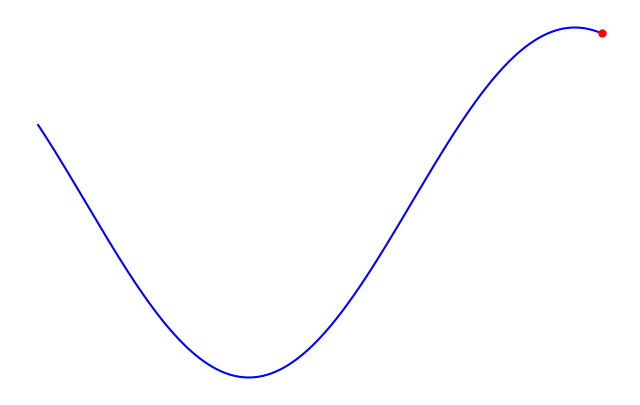

: 

In [10]:
def train_and_plot(lr, discount, epsilon_decay): # train the graph and show the 
    _, Qt = simulate(lr, discount, epsilon_decay, return_table = True) # get a Q table given hyper params 
    N = 400 # thanks Bill Leonard
    x = np.linspace(*POSITION_SPACE, N) # linearly spaced array across the positon space with N indexes 
    fn = lambda x: np.sin(3*x) # function that turns x position to y value (makes the mountians)
    y = fn(x) # create y array 
    fig, ax = plt.subplots(1, 1, figsize = (8, 5)) # create a figure and axes
    camera = Camera(fig) # create the Camera for the animation 
    p, v = -.5, 0. # init and v 
    while p < POSITION_SPACE[1]: # run sim until 
        a = Qt.get_best_action(p, v) # get the best action given the state
        p, v = Qt.update_state(p, v, a) # update the state based on the action 
        ax.plot(x, y, c = 'b', zorder=0) # plot mounitans repeative but im not memory constrained so im not going to rewrite
        ax.scatter(p, fn(p), s = 25, c = 'r', zorder=5) # plot where the mountian car is, having a z order larger than the line specifies this will be on top
        ax.set_axis_off()
        camera.snap() # snap the frame 
    animation = camera.animate()
    animation.save('mountaincar.gif', writer='Pillow') # save the animation as a gif (located in this folder)
  
if __name__ == "__main__": # 
    train_and_plot(.894, .282, .640)
    #animation.save('mountaincar.gif', writer='Pillow') # save the animation as a gif (located in this folder)